In [1]:
using LaTeXStrings
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
;

In [2]:
using Distributions
using RCall

# Implement Exponential Family w/ Splines

In [3]:
m = 31 # discretization resolution
# discretized space of noise-free variables:
θvec = collect(linspace(-3,3,m))
p = 5 # number of parameters
Q = convert(Matrix{Float64}, R"splines::ns($θvec, $p)")
size(Q)

(31, 5)

**Plot spline basis**

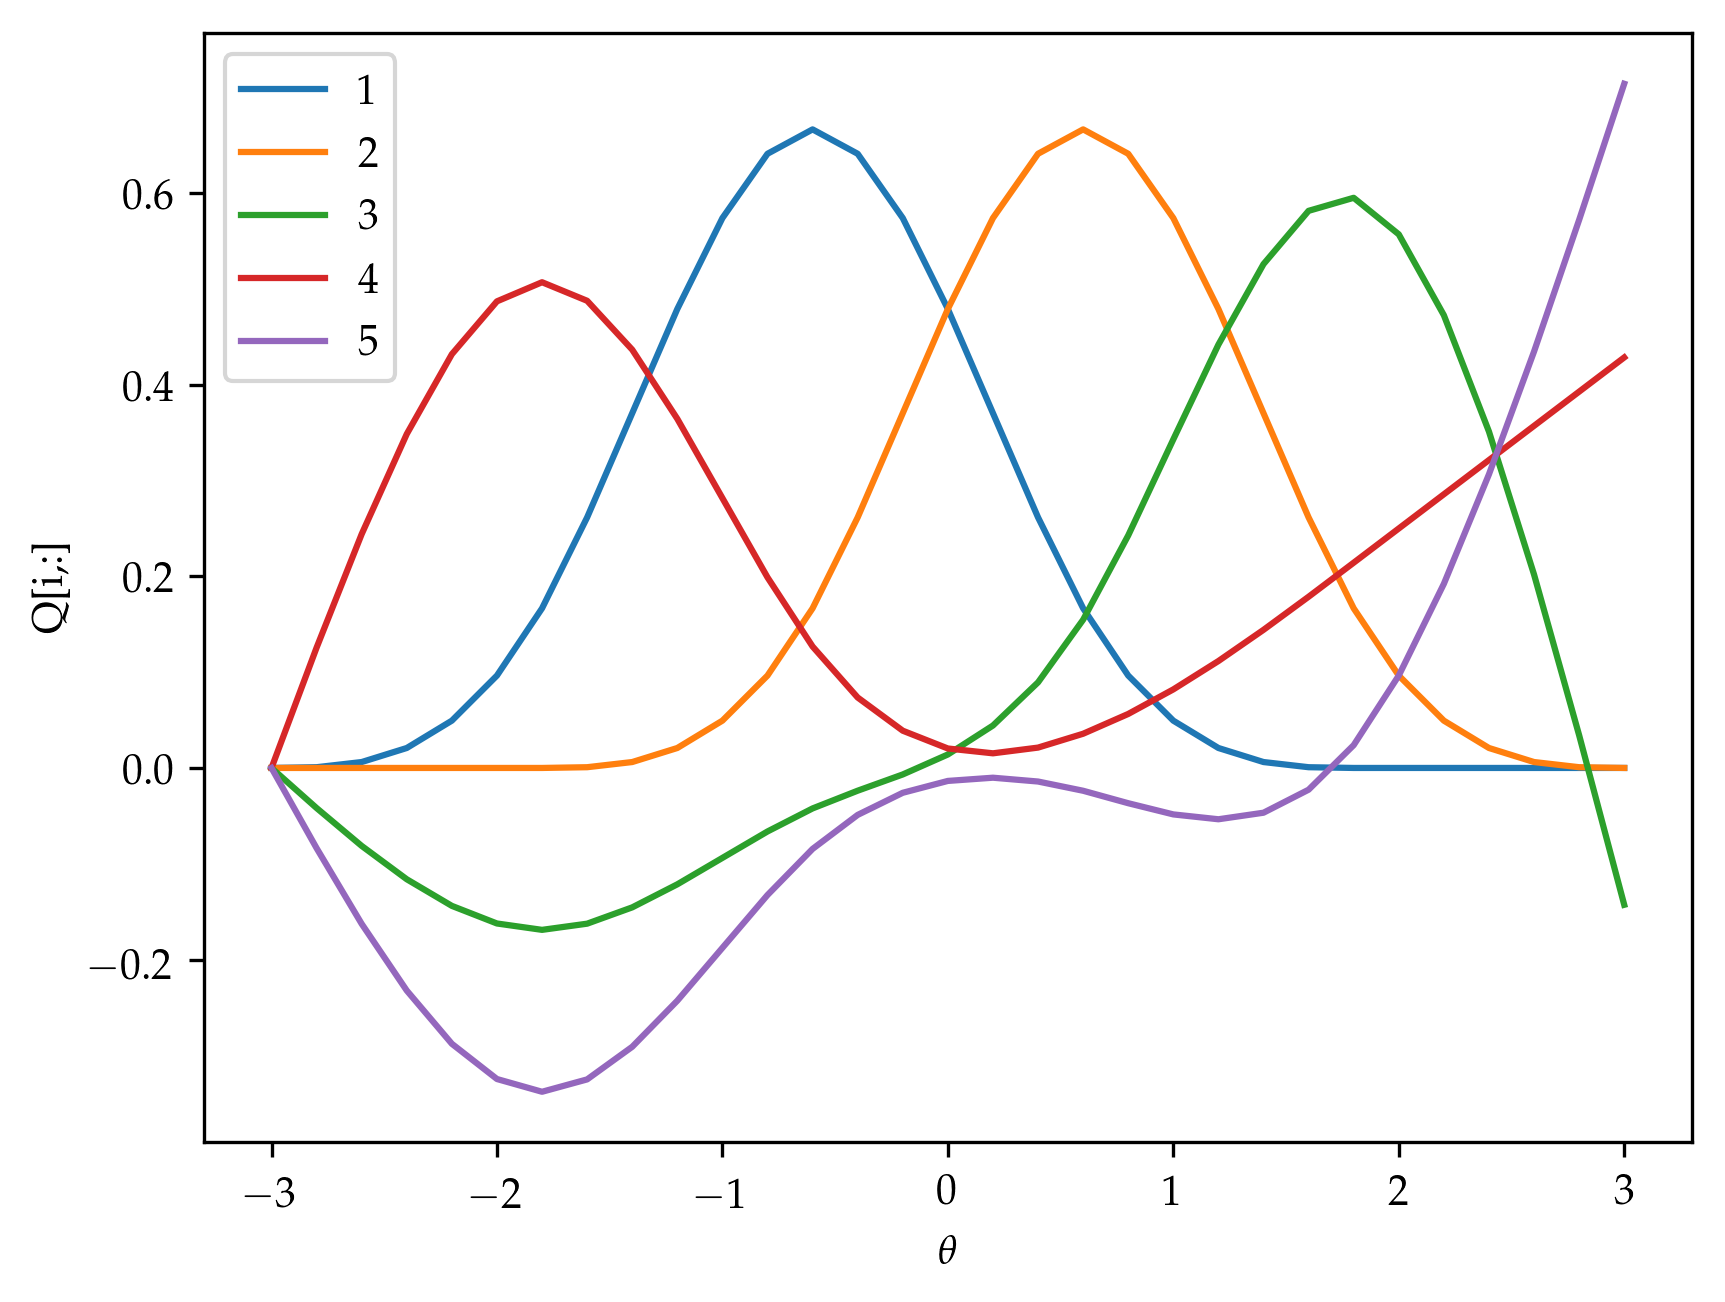

In [4]:
for param in 1:p
    plt.plot(θvec, Q[:, param], label=string(param))
end
plt.legend(loc="best")
plt.xlabel(L"\theta")
plt.ylabel("Q[i,:]")
;

**Generate a random distribution**

We create a random distribution by using random numbers for the parameter vector $\alpha$.

In [5]:
α = randn(p)

expQα = exp.(Q*α)
φ_α = log(sum(expQα))
g_α = exp.(Q*α - φ_α) # normalized
;

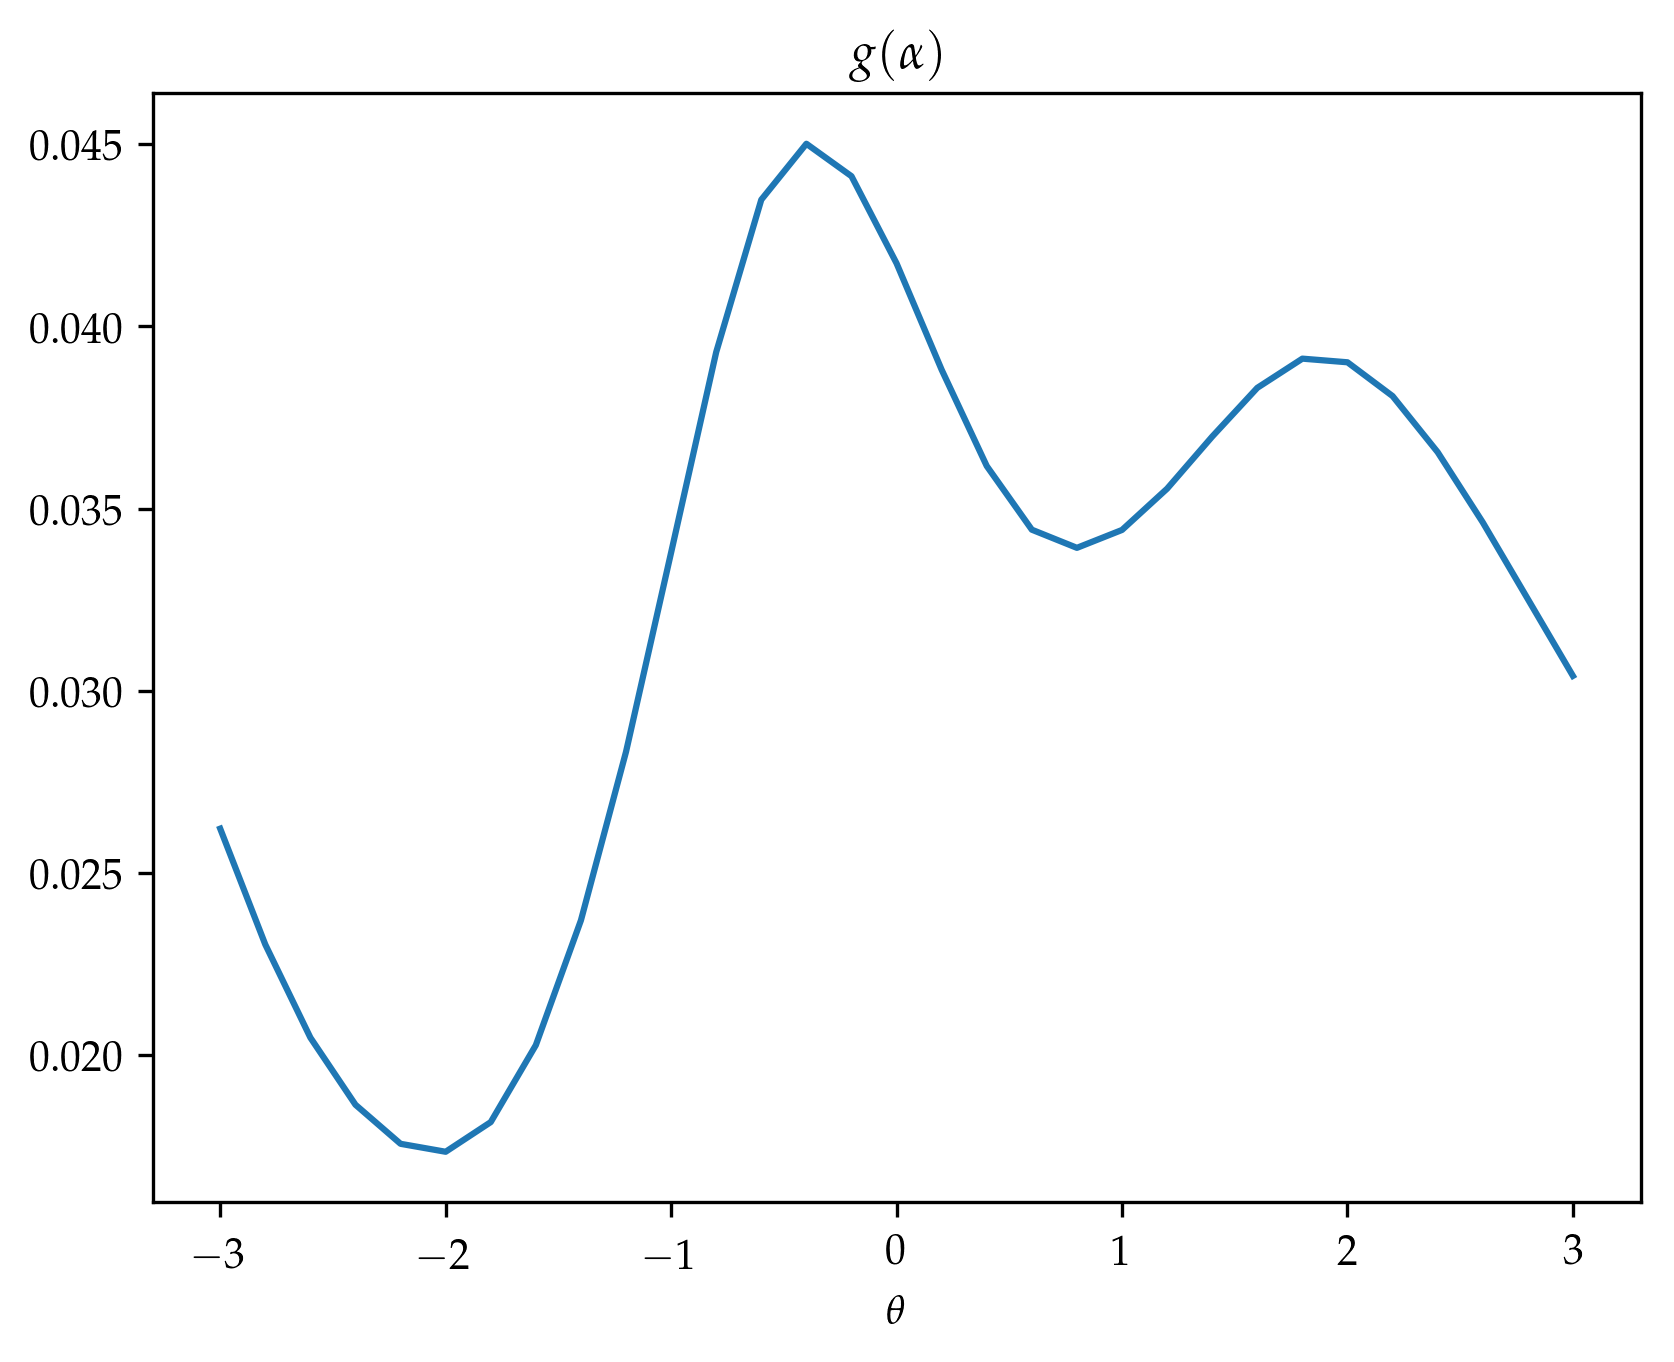

In [6]:
plt.plot(θvec, g_α)
plt.title(L"g(\alpha)")
plt.xlabel(L"\theta")
;

**Now let's do it a few times**

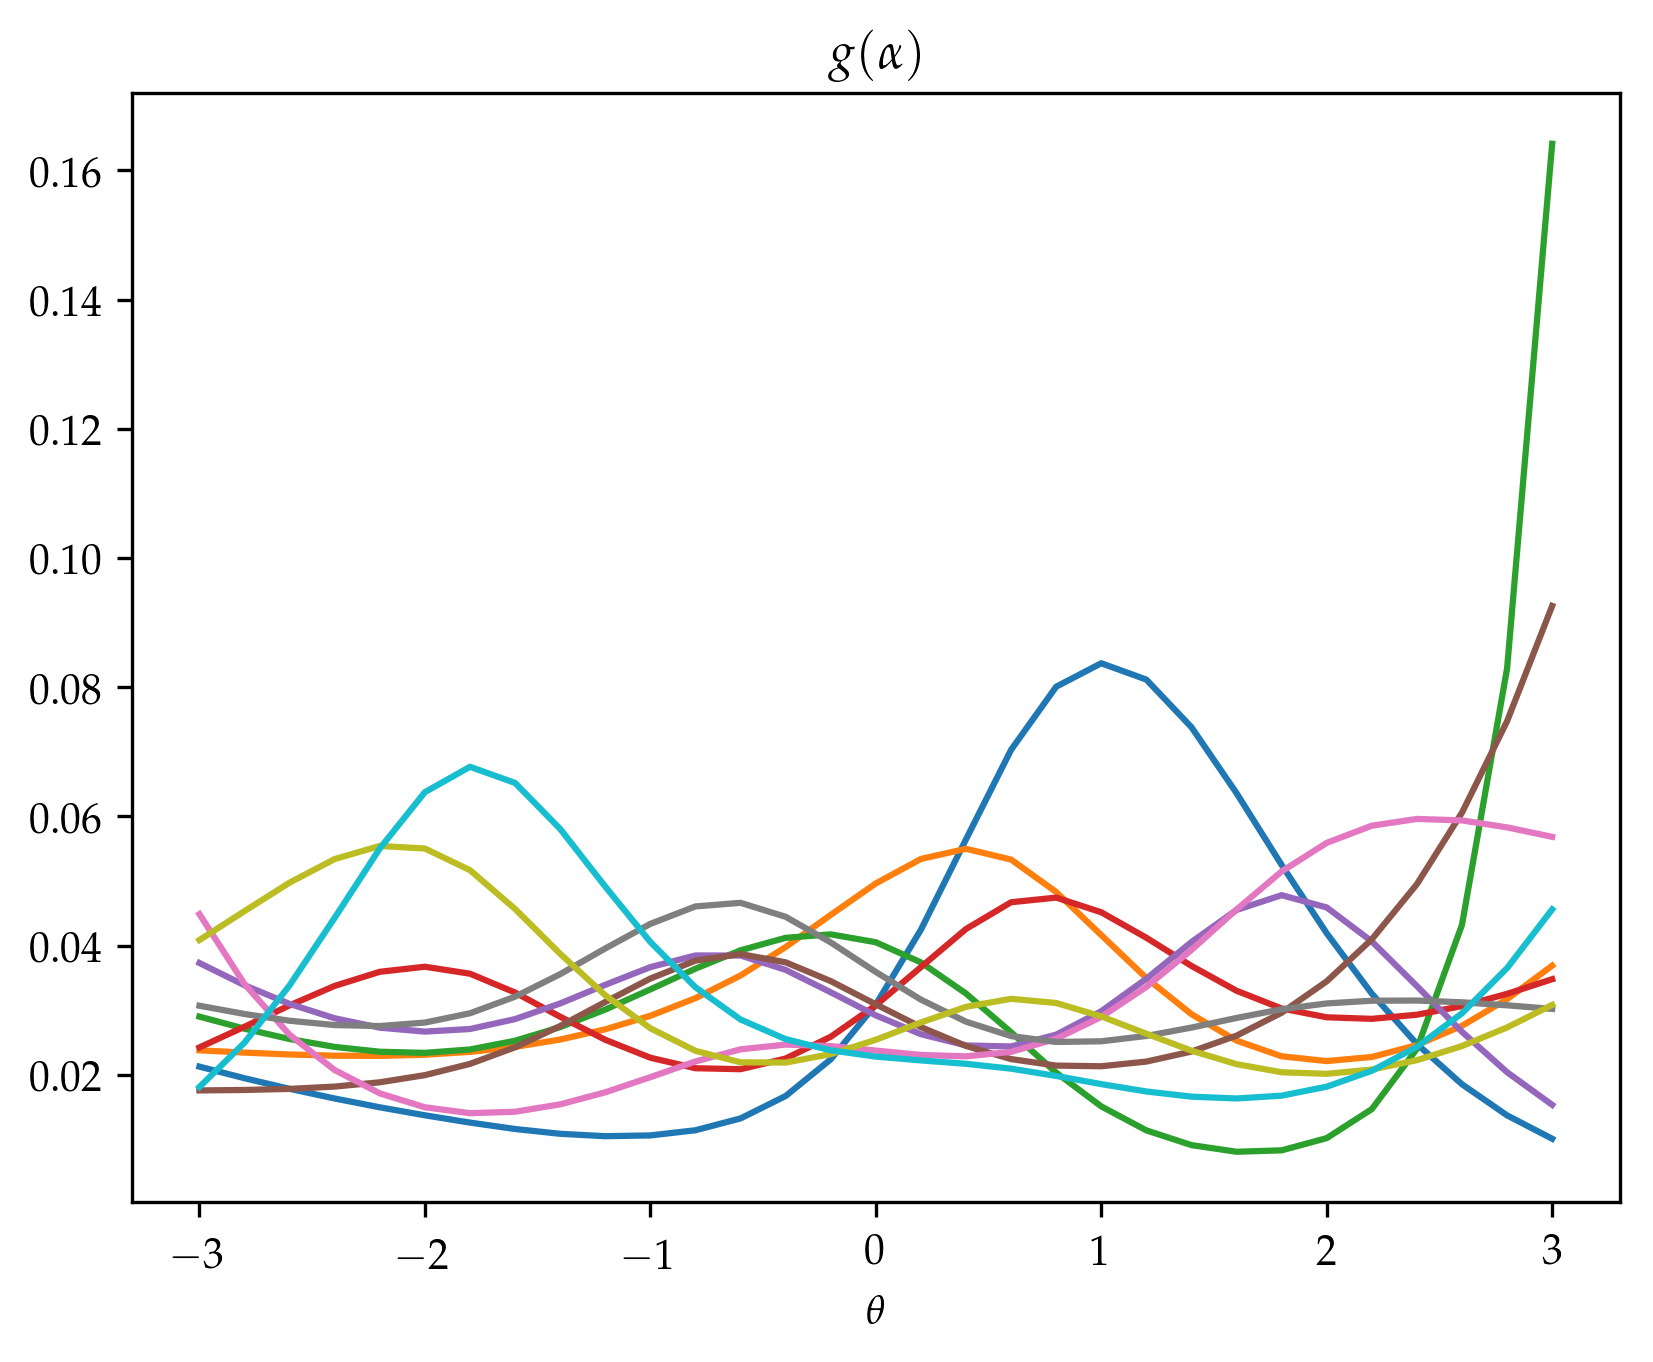

In [7]:
for _ in 1:10
    α = randn(p)
    expQα = exp.(Q*α)
    φ_α = log(sum(expQα))
    g_α = exp.(Q*α - φ_α) # normalized
    plt.plot(θvec, g_α)
end
plt.title(L"g(\alpha)")
plt.xlabel(L"\theta")
;

# Module

I put this family of distributions into a module for easy re-use.
The code is cleaned-up a bit, but there's otherwise nothing new here.

In [8]:
module ExpoFamSpline
    import Distributions: params, partype,
                          logpdf, pdf,
                          DiscreteUnivariateDistribution, 
                          insupport
    using RCall
    function spline_basis(domain, p)
        R_spline = R"splines::ns($domain, $p)"
        return convert(Matrix{Float64}, R_spline)
    end
    
    struct ExpoSpline{T<:Real} <: DiscreteUnivariateDistribution
        domain::Vector{Float64}
        Qbasis::Matrix{Float64} # basis matrix
        αcoef::Vector{T} # α
        Qα::Vector{T}
        φ_α::T # normalization constant
    end
    function ExpoSpline(domain, Qbasis::Matrix{Float64}, αcoef::Vector{T}) where {T <: Real}
        Qα = Qbasis * αcoef
        φ_α = log_sum_exp(Qα) # equation (10)
        return ExpoSpline(domain, Qbasis, αcoef, Qα, φ_α)
    end
    function ExpoSpline(domain, p::Int, αcoef::Vector{T}) where {T <: Real}
        Q = spline_basis(domain, p)
        return ExpoSpline(domain, Q, αcoef)
    end 
    
    params(d::ExpoSpline) = (d.αcoef)
    partype(d::ExpoSpline{T}) where {T<:Real} = T
    insupport
    
    function log_sum_exp(x)
        # https://en.wikipedia.org/wiki/LogSumExp
        max_x = maximum(x)
        log_sum_exp_x = max_x .+ log(sum(exp.(x .- max_x)))
        return log_sum_exp_x
    end
    logpdf(d::ExpoSpline{T}) where T = d.Qα .- d.φ_α             # equation (9)
    pdf(d::ExpoSpline{T}) where T = exp.(logpdf(d))
    logpdf(d::ExpoSpline{T}, j::Int) where {T} = d.Qα[j] - d.φ_α # equation (9)
    function logpdf(d::ExpoSpline{T}, x::Real) where {T}
        j = findfirst(d.domain, x)
        return logpdf(d, j)
    end
    function pdf(d::ExpoSpline{T}, x::Real) where {T}
        return exp(logpdf(d, x))
    end
end

ExpoFamSpline

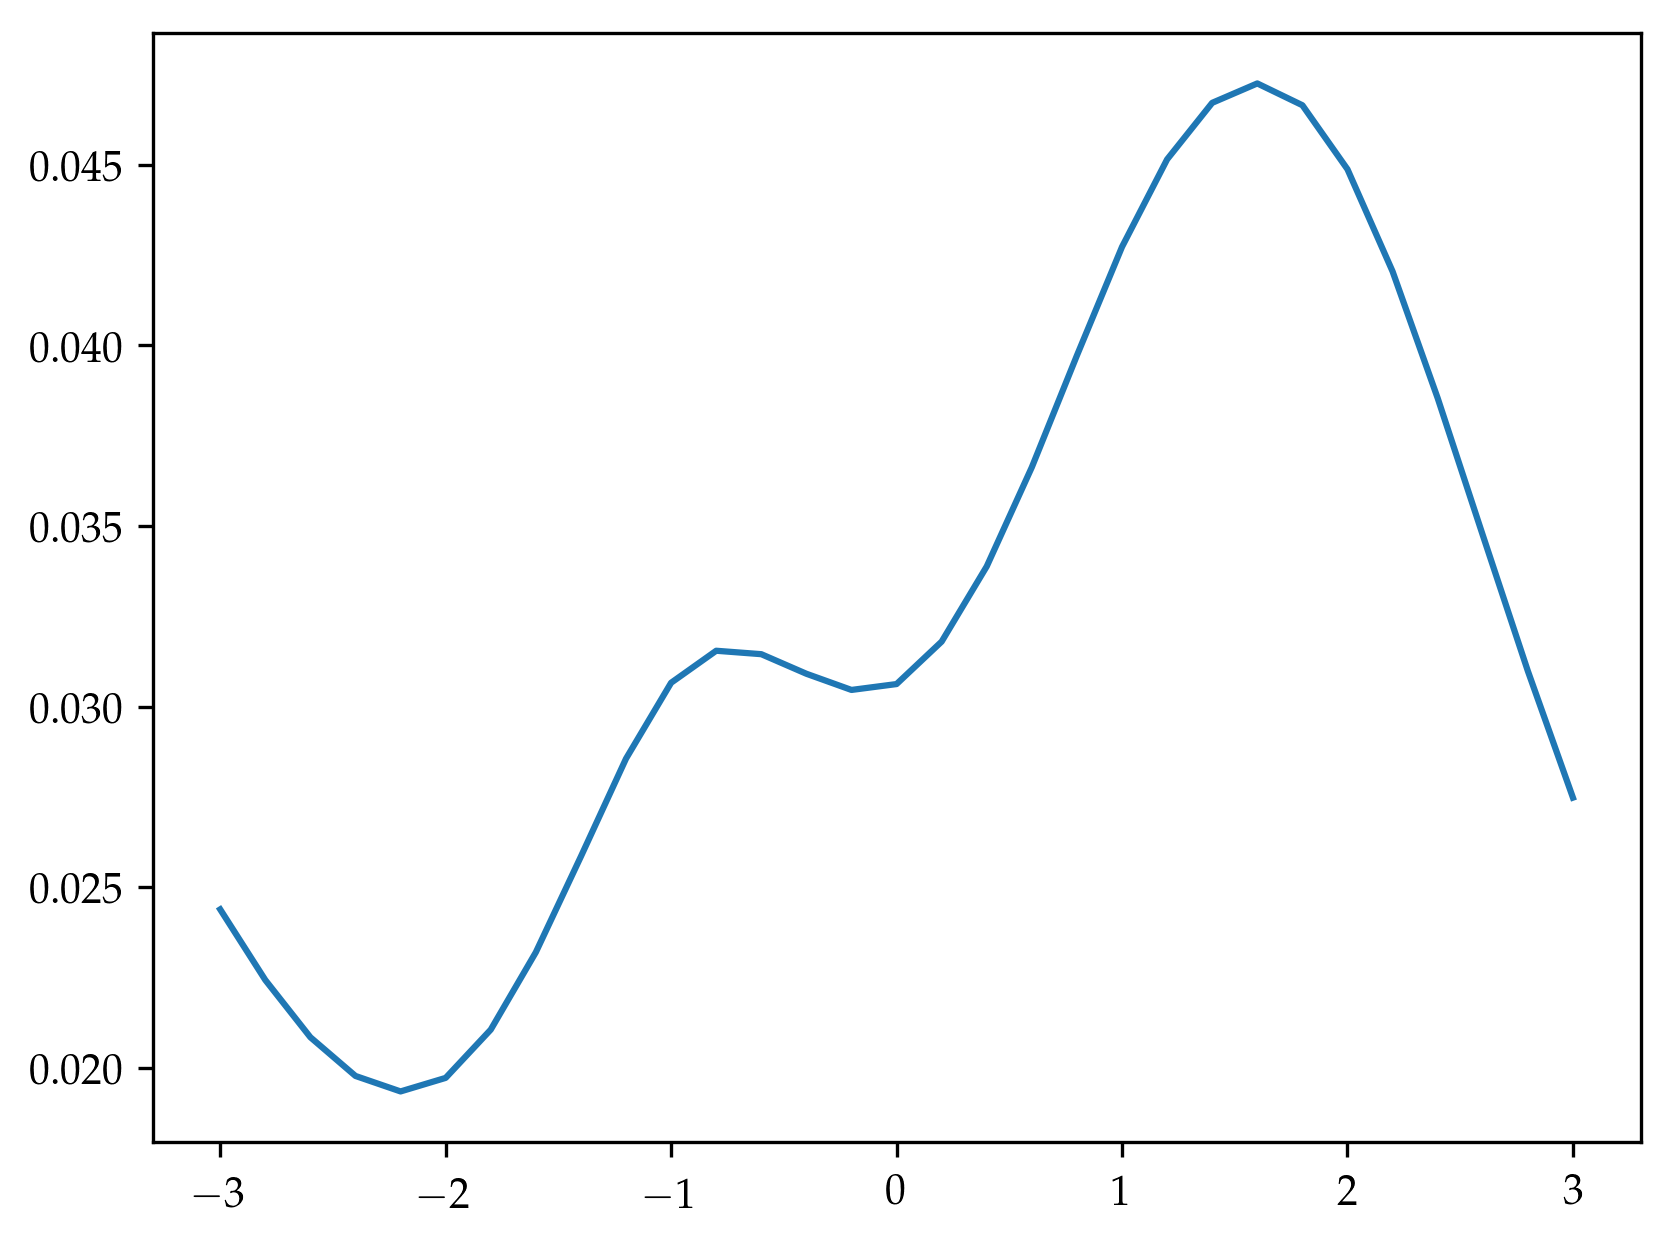

In [9]:
d = ExpoFamSpline.ExpoSpline(θvec, 6, randn(6))
plt.plot(θvec, pdf.(d))
;

Next steps:
- compute the derivative of the PDF
- maximize the PDF to obtain the MLE given noise-free data
- add a noise likelihood and propagate the gradient
- maximize the likelihood to obtain the MLE given noisy data